### Create figures showing OpenNeuro usage

note: analytics data from 2018 through 2023 are in ../data/openneuro/analytics_20180101-20231231.csv (from GA3)

newer GA4 data are in ../data/openneuro/analytics_...


In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

datadir = '../data/openneuro'
figdir = '../figures'


In [18]:
# load and process metadata

metadata = pd.read_csv(os.path.join(datadir, 'metadata_06182021.csv'), skiprows=1)
metadata['Dataset made public (MM/DD/YYYY)'] = pd.to_datetime(metadata['Dataset made public (MM/DD/YYYY)'])
data_paper_dois = metadata['DOI of paper associated with DS (from submitter lab)'].unique()
print(f'{data_paper_dois.shape[0]} DOIs associated with dataset (from submitter)')

user_paper_dois = metadata['DOI of paper because DS on OpenNeuro'].unique()
print(f'{user_paper_dois.shape[0]} DOIs associated with dataset (from user)')

df_sorted = metadata.sort_values('Dataset made public (MM/DD/YYYY)')
df_sorted['ones'] = 1
df_sorted['cumulative'] = df_sorted['ones'].cumsum()
df_sorted['cumulative_subjects'] = df_sorted['# of subjects'].cumsum()



376 DOIs associated with dataset (from submitter)
29 DOIs associated with dataset (from user)


In [57]:
# load and process analytics
analytics_ga3_df = pd.read_csv(os.path.join(datadir, 'analytics_20180701-20231231_daily.csv'),
                               skiprows=6).dropna()
analytics_ga3_df['Date'] = pd.to_datetime(analytics_ga3_df['Day Index'])
del analytics_ga3_df['Day Index']
analytics_ga3_df['Users_int'] = analytics_ga3_df['Users'].str.replace(',', '').astype(int)
analytics_ga3_df = analytics_ga3_df.set_index('Date')


In [60]:

# remove dec 2023 since data are not complete
specific_date = pd.Timestamp('2023-9-01')

# Filter the DataFrame for dates later than the specific date
analytics_ga3_df = analytics_ga3_df[analytics_ga3_df.index < specific_date]


monthly_sum = analytics_ga3_df.resample('M').sum()
monthly_sum


/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_35006/2285385268.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_sum = analytics_ga3_df.resample('M').sum()


,Users_int
Date,
2018-07-31,4316
2018-08-31,3832
2018-09-30,4319
2018-10-31,5845
2018-11-30,5086
...,...
2023-04-30,17335
2023-05-31,18010
2023-06-30,16069


In [52]:
# now process GA4 data
# need to pull out just the first part of the file containing users
ga4_startdate = '02-01-2023'
ga4_file = os.path.join(datadir, f"analytics_ga4_{ga4_startdate.replace('-','')}-01312024.csv")
                        
with open(ga4_file, 'r') as f:
    lines = [i.strip() for i in f.readlines()]

# drop the lines after the first blank line
goodlines = []
for i, line in enumerate(lines):
    if line == '':
        break
    elif line.find('#') == 0 or line.find('Nth') == 0:
        continue
    goodlines.append(line.split(','))


analytics_ga4_df = pd.DataFrame(goodlines, columns=['day', 'numusers'])
analytics_ga4_df['date'] = index = pd.date_range(start=ga4_startdate, periods=analytics_ga4_df.shape[0], freq='D')
del analytics_ga4_df['day']
analytics_ga4_df['Users_int'] = analytics_ga4_df['numusers'].str.replace(',', '').astype(int)

analytics_ga4_df = analytics_ga4_df.set_index('date')

monthly_sum_ga4 = analytics_ga4_df.resample('M').sum()
monthly_sum_ga4


/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_35006/3472345160.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_sum_ga4 = analytics_ga4_df.resample('M').sum()


,Users_int
date,
2023-02-28,14916
2023-03-31,18534
2023-04-30,16273
2023-05-31,17953
2023-06-30,16060
2023-07-31,15579
2023-08-31,15885
2023-09-30,17107
2023-10-31,20914


Text(0, 0.5, 'Users per month')

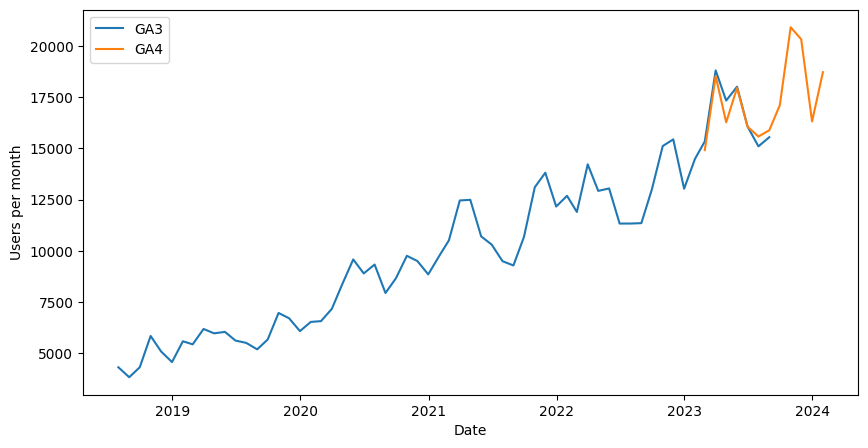

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_sum.index, monthly_sum['Users_int'], label='GA3')
plt.plot(monthly_sum_ga4.index, monthly_sum_ga4['Users_int'], label='GA4')
plt.legend(['GA3', 'GA4'])
plt.xlabel('Date')
plt.ylabel('Users per month')

In [19]:
# load and process usage data
usage_data = pd.read_csv(os.path.join(datadir, 'users.csv'))
usage_data['Date'] = pd.to_datetime(usage_data['Month of Year'], format='%b %Y')
usage_data = usage_data.drop('Month of Year', axis=1).set_index('Date')

download_data = pd.read_csv(os.path.join(datadir, 'web_downloads.csv'))
#download_data = download_data.set_index('Year Month')
download_data['Date'] = pd.to_datetime(download_data['Year Month'], format='%b %Y')
download_data = download_data.drop('Year Month', axis=1)
download_data = download_data.set_index('Date')

download_gb_data = pd.read_csv(os.path.join(datadir, 'gb_downloaded.csv'))
download_gb_data = download_gb_data.groupby('Year Month').sum()
download_gb_data['TB downloaded'] = download_gb_data['GB downloaded'] / 1000
download_gb_data['Date'] = pd.to_datetime(download_gb_data.index, format='%b %Y')
download_gb_data = download_gb_data.set_index('Date')

alldata = download_data.join(download_gb_data, how='inner').join(usage_data, how='inner')
alldata = alldata.reset_index()
print(f'total download volume: {alldata.iloc[18:,3].sum()} TB')
alldata.iloc[18:,:]

total download volume: 406.3416841125327 TB


,Date,Web downloads,GB downloaded,TB downloaded,Sessions,Users
18,2020-05-01,1345,37087.332923,37.087333,12299,6862
19,2020-06-01,1283,39213.028653,39.213029,11400,6437
20,2020-07-01,1395,47583.453644,47.583454,12091,6694
21,2020-08-01,1273,66526.433802,66.526434,10346,5675
22,2020-09-01,1298,24654.956239,24.654956,11231,6205
23,2020-10-01,1535,19879.198595,19.879199,12415,6939
24,2020-11-01,1274,23113.170929,23.113171,12317,6664
25,2020-12-01,1063,40591.518353,40.591518,11515,6350
26,2021-01-01,1096,17955.671453,17.955671,12585,7002
27,2021-02-01,1284,24969.014733,24.969015,13636,7470


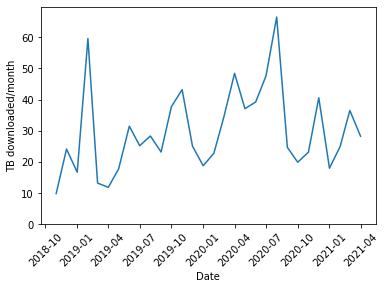

In [20]:
p = sns.lineplot(x='Date', y='TB downloaded', data=alldata)
plt.xticks(rotation=45)
plt.ylim([0, alldata['TB downloaded'].max()*1.05])
plt.ylabel('TB downloaded/month')

plt.savefig(os.path.join(figdir, 'TB_downloaded.png'))

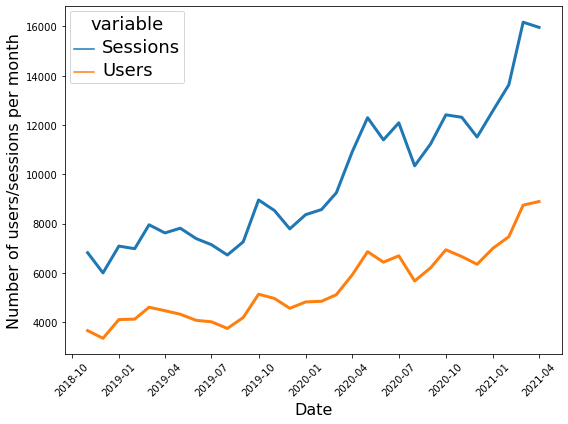

In [21]:
plt.figure(figsize=(8,6))
# plot sessions/users
userdata = alldata[['Date', 'Sessions', 'Users']]
userdata_long = pd.melt(userdata, id_vars='Date')
p = sns.lineplot(x='Date', y='value', hue='variable', data=userdata_long, linewidth=3)
plt.xticks(rotation=45)
plt.ylabel('Number of users/sessions per month', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='18') # for legend text
plt.setp(plt.gca().get_legend().get_title(), fontsize='18') # for legend title

plt.tight_layout()
plt.savefig(os.path.join(figdir, 'sessions_users.png'))


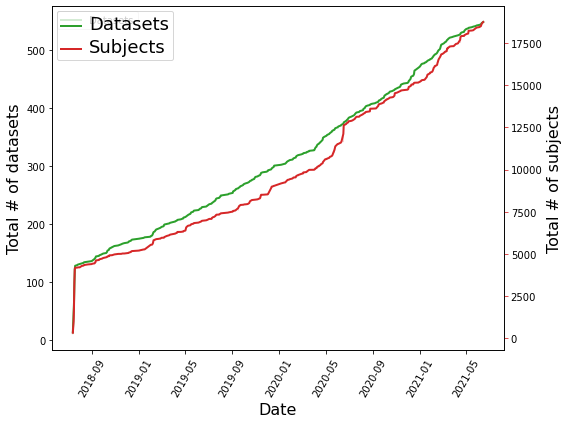

In [22]:
# plot datasets

fig, ax1 = plt.subplots(figsize=(8,6))
color = 'tab:green'
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Total # of datasets', fontsize=16) #, color=color)
ax1 = sns.lineplot(x='Dataset made public (MM/DD/YYYY)', y='cumulative', 
                    data=df_sorted, color=color, label='Datasets', linewidth=2)
ax1.tick_params(axis='y')
plt.xticks(rotation=60)
#ax1.legend()

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total # of subjects', fontsize=16) #, color=color)
ax2 = sns.lineplot(x='Dataset made public (MM/DD/YYYY)', y='cumulative_subjects',
                   data=df_sorted, color=color, label='Subjects', linewidth=2)
ax2.tick_params(axis='y', color=color)
#ax2.legend(loc=1)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.setp(ax2.get_legend().get_texts(), fontsize='18') # for legend text

plt.tight_layout()
plt.savefig(os.path.join(figdir, 'datasets_subjects.png'))